# mpl

> matplotlib tools

In [ ]:
#| default_exp mpl

In [ ]:
#| hide
from nbdev.showdoc import *
from aaron.defaults import setup_np

In [ ]:
#| hide
setup_np()

In [ ]:
#| export
import fastcore.all as fc
from itertools import zip_longest
import matplotlib.pyplot as plt
import math
from matplotlib.figure import Figure
import numpy as np
import torch
from typing import Tuple

In [ ]:
#| export
def heatmap(data, cmap='cool', vmin=None, vmax=None):
    fig, ax = plt.subplots()
    heatmap = ax.pcolormesh(data, cmap=cmap, edgecolors='k', linewidths=0.5, vmin=vmin, vmax=vmax)

    # Configure axis
    ax.set_xticks(np.arange(data.shape[1]) + 0.5)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ax.xaxis.tick_top()
    ax.set_xticklabels(np.arange(data.shape[1]))

    # Center tick labels on cells
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    # Reverse the y-axis
    ax.invert_yaxis()

    # Display values centered in each cell
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Calculate the luminance of the cell color
            cell_color = heatmap.cmap(heatmap.norm(data[i, j]))
            luminance = 0.299 * cell_color[0] + 0.587 * cell_color[1] + 0.114 * cell_color[2]
            
            # Choose a text color based on the luminance
            text_color = "w" if luminance < 0.5 else "k"
            
            ax.text(j + 0.5, i + 0.5, f"{data[i, j]:.2f}", ha="center", va="center", fontsize="small", color=text_color)

    # Set the left spine labels to count down from 0 to 9
    ax.yaxis.set_ticklabels([f"{data.shape[0] - i - 1}" for i in range(data.shape[0]-1, -1, -1)])

    # Add colorbar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.ax.set_ylabel('Value')

    plt.show()

In [ ]:
# Example usage
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

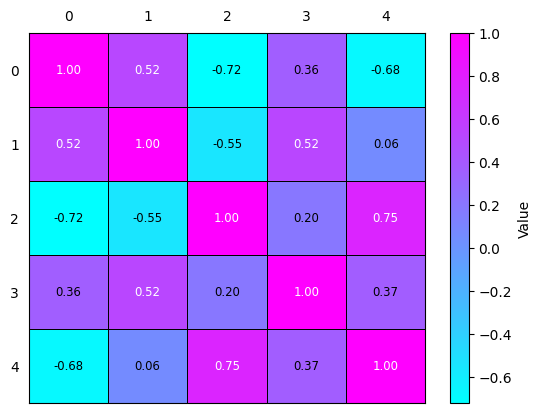

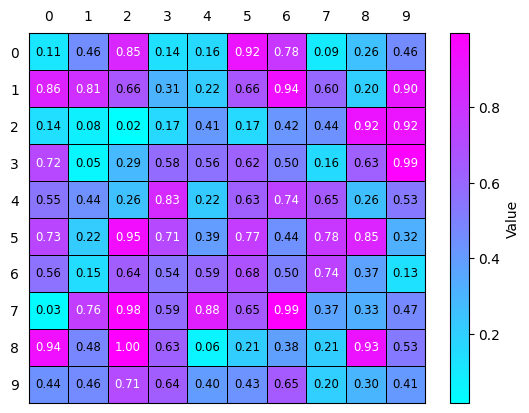

In [ ]:
data_np = cosine_similarity(np.random.randn(5,5))
data_torch = torch.rand(10, 10)

heatmap(data_np)
heatmap(data_torch)

In [ ]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int=1, # Number of rows in returned axes grid
    ncols: int=1, # Number of columns in returned axes grid
    figsize: tuple=None, # Width, height in inches of the returned figure
    imsize: int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
) -> Tuple[Figure, plt.Axes]: 
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [ ]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [ ]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [ ]:
#| export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()